# <center> Railroad Segmentation (Binary) </center>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101, deeplabv3_resnet50, fcn_resnet50, fcn_resnet101
import numpy as np
import os

# from data_handler import SegmentationDataset, get_data, sample_points
# from transformer import SegmentationTransform
# from train import train_model
# from utils import plot_overlay, get_filepaths, load_images, dice_coeff
# from validate import validate_model

#### Constants

In [2]:
GOOGLE_COLAB = False

DATA_DIR = 'segmentation/data/segmentation_data/'
if not GOOGLE_COLAB:
    DATA_DIR = os.path.realpath(DATA_DIR)

FEATURES = ['roads', 'railroads', 'wetlands']
POSITIVE = 'railroads'
NEGATIVE = [feature for feature in FEATURES if feature != POSITIVE]

N_SAMPLES = 400 # for each class
N_AUG_POS = 4
N_AUG_NEG = 0
N_POS = N_SAMPLES // N_AUG_POS
N_NEG = N_SAMPLES

BATCH_SIZE = 10

ROTATION_RANGE = 180
WINDOW_SIZE = 320

NUM_WORKERS = 2

N_EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
AUX_BRANCH = None

LOAD_MODEL = False
LOAD_MODEL_PATH = 'checkpoints/epoch_5.pth'
CHECKPOINTS_DIR = 'checkpoints/'

MASK_THRESHOLD = 0.5

#### Settings for Google Collaboratory

In [3]:
if GOOGLE_COLAB:
    from google.colab import drive

    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive')

    assert os.path.exists(DATA_DIR), 'DATA_DIR does not exist in path'
    assert os.path.exists(CHECKPOINTS_DIR), 'CHECKPOINTS_DIR does not exist'
    
    import sys
    sys.path.append('/content/drive/My Drive')

In [4]:
from data_handler import SegmentationDataset, get_data, sample_points
from transformer import SegmentationTransform
from train import train_model
from utils import plot_overlay, get_filepaths, load_images, dice_coeff
from validate import validate_model

#### Starting with data

- Read dir to gather files
- Maps start with 'map_'
- Masks start with 'mask_'
- Rest have class type in their names
    - eg. railroads.txt

In [5]:
maps, masks, neg_files = get_filepaths(DATA_DIR, POSITIVE, NEGATIVE)

- Load maps and masks
- Caching them since maps are heavy (heavy IO)

In [6]:
LOADED_MAPS = load_images(maps)
LOADED_MASKS = load_images(masks, grayscale=True)
# LOADED_MAPS[0].shape

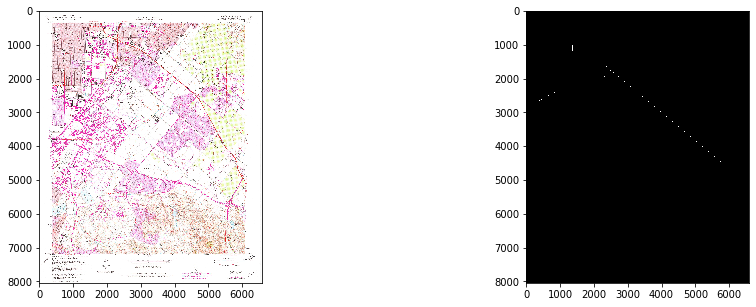

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.imshow(LOADED_MAPS[1])
plt.subplot(1,2,2)
plt.imshow(LOADED_MASKS[1], cmap='gray')
plt.show()

- Sample N_POS pixels (white) from all the pixels that belong to the positive class and write to pos.txt
- Sample N_NEG pixels (black) for each of the negative class and write to neg{}.txt

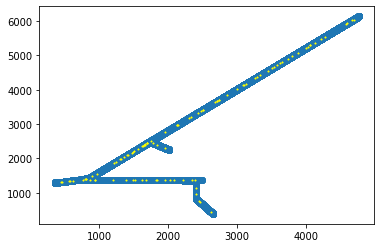

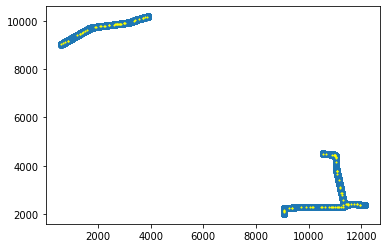

In [7]:
sample_points(maps, masks, neg_files, N_POS, N_NEG, representors=False, plot_pos=True)

#### Create Datasets and Data Loaders

In [8]:
# Default: val_size=0.1, shuffle=True, augment=True

train_data, val_data = get_data(maps, LOADED_MAPS, N_AUG_POS, N_AUG_NEG, WINDOW_SIZE, ROTATION_RANGE)
n_train, n_val = len(train_data), len(val_data)
n_train, n_val

(1620, 180)

In [9]:
image_tf = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE, image_tf=image_tf)
# transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE)

In [10]:
train_dataset = SegmentationDataset(train_data, transformer, WINDOW_SIZE)
val_dataset = SegmentationDataset(val_data, transformer, WINDOW_SIZE)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

#### Simple Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


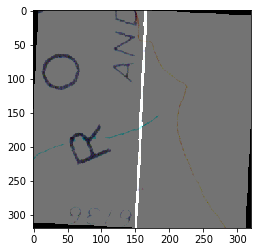

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


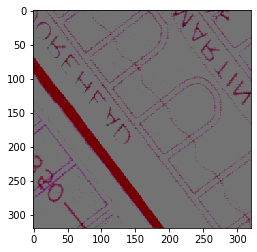

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


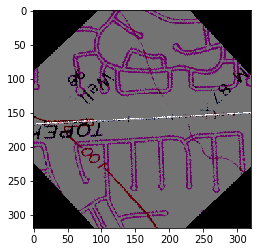

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


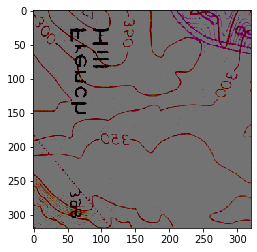

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


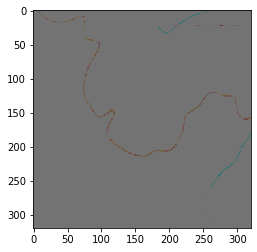

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


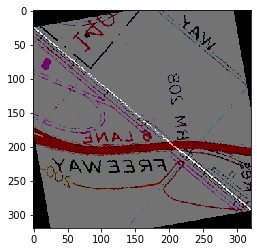

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


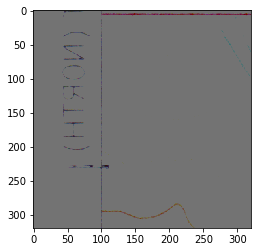

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


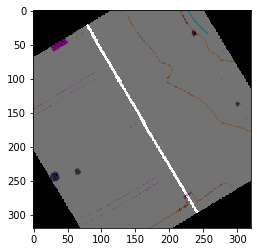

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


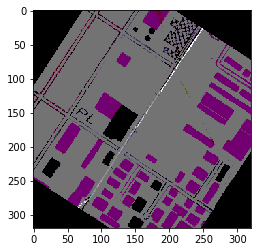

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


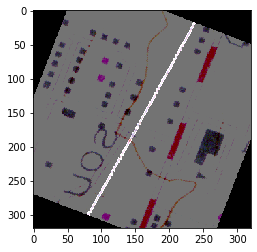

In [31]:
for b, batch in enumerate(val_loader):
    if b==1: break
    for i in range(batch['images'].shape[0]):
        plot_overlay(batch['images'][i], batch['masks'][i])

In [13]:
p = (torch.randn((5,1,320,320)) > MASK_THRESHOLD).int()
t = torch.randint_like(p, low=0, high=1+1)
dice_coeff(p, t).item()

0.3801564574241638

In [14]:
(
    dice_coeff(torch.zeros((5,1,320,320)), torch.ones((5,1,320,320))),
    dice_coeff(torch.zeros((5,1,320,320)), torch.zeros((5,1,320,320))),
    dice_coeff(torch.ones((5,1,320,320)), torch.ones((5,1,320,320))),
)

(tensor([0.]), tensor([0.]), tensor([1.]))

### Load Model

#### DeepLabV3 ResNet101

In [15]:
model = deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21)
# print(model)
# print(model.classifier)
# print(model.aux_classifier)
# print(model.classifier[4], model.aux_classifier[4])

# Replace existing conv layers with new ones to map output to 1 class (binary segmentation)
model.classifier[4] = nn.Conv2d(256, 1, (1,1))
model.aux_classifier[4] = nn.Conv2d(256, 1, (1,1))
AUX_BRANCH = True

#### DeepLabV3 ResNet50

In [9]:
model = deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)
print(model)
print(model.classifier)
print(model.aux_classifier)
# print(model.classifier[4], model.aux_classifier[4])

# # Replace existing conv layers with new ones to map output to 1 class (binary segmentation)
# model.classifier[4] = nn.Conv2d(256, 1, (1,1))
# model.aux_classifier[4] = nn.Conv2d(256, 1, (1,1))

NotImplementedError: pretrained deeplabv3_resnet50_coco is not supported as of now

#### FCN ResNet101

In [15]:
model = fcn_resnet101(pretrained=True, progress=True, num_classes=21)
print(model)
# print(model.classifier)
# print(model.aux_classifier)
# print(model.classifier[4], model.aux_classifier[4])

# Replace existing conv layers with new ones to map output to 1 class (binary segmentation)
model.classifier[4] = nn.Conv2d(256, 1, (1,1))
model.aux_classifier[4] = nn.Conv2d(256, 1, (1,1))

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

#### FCN ResNet50

In [10]:
model = fcn_resnet50(pretrained=True, progress=True, num_classes=21)
# print(model)
# print(model.classifier)
# print(model.aux_classifier)
# print(model.classifier[4], model.aux_classifier[4])

# # Replace existing conv layers with new ones to map output to 1 class (binary segmentation)
# model.classifier[4] = nn.Conv2d(256, 1, (1,1))
# model.aux_classifier[4] = nn.Conv2d(256, 1, (1,1))

NotImplementedError: pretrained fcn_resnet50_coco is not supported as of now

In [16]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH, map_location=DEVICE))
    
model = model.to(device=DEVICE)

### Training

In [17]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.BCEWithLogitsLoss()

In [18]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
train_model(model, train_loader, val_loader, n_train, n_val, criterion, optimizer, scheduler,
            LEARNING_RATE, N_EPOCHS, DEVICE, CHECKPOINTS_DIR, AUX_BRANCH)